# InceptionV3 Training using pretrained layers

# Importing Libraries

In [4]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import PIL

# Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')
model_dir = '/content/drive/My Drive/Omdena_Hyderabad/InceptionV3_Distracted_Driver_Classification'
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
# !ls -ltra '{model_dir}'/..
!ls -ltra '{model_dir}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 2839261
drwx------ 2 root root       4096 Oct 24 12:59 images
-rw------- 1 root root 2906928128 Oct 24 15:33 image_data.npy
-rw------- 1 root root     470463 Oct 25 09:31 InceptionV3_Distracted_Driver_Classification_YeYintThu.ipynb


In [6]:
%cd /content/drive/My Drive/Omdena_Hyderabad/InceptionV3_Distracted_Driver_Classification
!pwd

/content/drive/My Drive/Omdena_Hyderabad/InceptionV3_Distracted_Driver_Classification
/content/drive/My Drive/Omdena_Hyderabad/InceptionV3_Distracted_Driver_Classification


# Dataset Preprocessing

In [7]:
img_height, img_width = [180, 240]
batch_size = 32

In [8]:
train_data_dir = 'images'
classes = ['safe driving', 'texting-right', 'talking on the phone-right', 'texting-left', 'talking on the phone-left', 'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
# image_data = []
class_data = []
i = 0
for category in classes:
    class_dir = os.path.join(train_data_dir, category)
    for filename in os.listdir(class_dir):
      # image = PIL.Image.open(class_dir + "/" + filename)
      # image = image.resize((240, 180), resample=0)
      # numpydata = np.asarray(image)
      # image_data.append(numpydata)
      class_data.append(i)
    i += 1
# image_data = np.array(image_data)
class_data = np.array(class_data)

In [9]:
image_data = np.load("image_data.npy")

In [10]:
image_data.shape

(22430, 180, 240, 3)

In [11]:
# np.save("image_data.npy", image_data)

In [12]:
labels = np.zeros((class_data.shape[0], 10))
for i in range(class_data.shape[0]):
    ind = class_data[i]
    labels[i][ind] = 1


In [13]:
class_data[0:63]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
labels[100:102]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2)

# Plotting function and Callback

Callback to stop a program once a desired performance is reached

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.99 and logs.get('val_acc') > 0.99):
            print("\nCancelling training as model has reached 99% accuracy and 99% validation accuracy!")
            self.model.stop_training = True

Function for plotting result

In [17]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

# Model Architecture

In [18]:
# Import Inception v3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
# pre_trained_model = InceptionV3(input_shape=(img_height, img_width, 3), include_top=False, weights = 'imagenet')
pre_trained_model = InceptionV3(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [19]:
# for layer in pre_trained_model.layers:
#     layer.trainable = False

In [20]:
pre_trained_model.summary()
# plot_model(pre_trained_model, to_file='inception_v3_model.png', show_shapes=False, show_layer_names=True)


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 119, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 119, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 119, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
last_layer = pre_trained_model.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 6, 2048)


In [22]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
model.summary()
# plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 119, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 119, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 119, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Training & Evaluation Process

In [24]:
# history = model.fit(image_data, labels, validation_split = 0.2, batch_size=batch_size, epochs=15)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=3)
model.save('model/')

Epoch 1/3
561/561 [==============================] - 358s 560ms/step - loss: 0.1535 - accuracy: 0.9551 - val_loss: 0.0536 - val_accuracy: 0.9891
Epoch 2/3
561/561 [==============================] - 309s 551ms/step - loss: 0.0242 - accuracy: 0.9946 - val_loss: 0.1244 - val_accuracy: 0.9918
Epoch 3/3
561/561 [==============================] - 309s 551ms/step - loss: 0.0219 - accuracy: 0.9962 - val_loss: 0.0371 - val_accuracy: 0.9940
INFO:tensorflow:Assets written to: model/assets


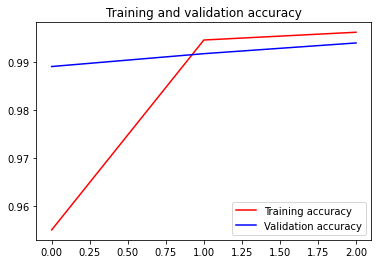

<Figure size 432x288 with 0 Axes>

In [25]:
plot_result(history)

In [26]:
print(model.evaluate(x_test, y_test))

141/141 [==============================] - 19s 134ms/step - loss: 0.0371 - accuracy: 0.9940
[0.03710593655705452, 0.9939813017845154]


# Confusion Matrix and Metrics



In [27]:
unique, counts = np.unique(class_data, return_counts=True)
dict(zip(unique, counts))

{0: 2489,
 1: 2267,
 2: 2317,
 3: 2352,
 4: 2326,
 5: 2312,
 6: 2325,
 7: 2002,
 8: 1911,
 9: 2129}

Confusion matrix, without normalization


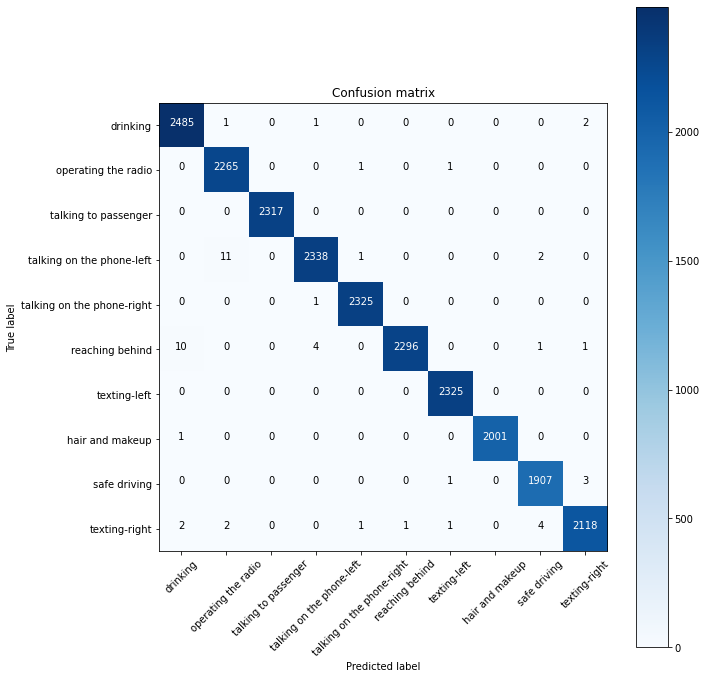

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

pred_labels = model.predict(image_data)
pred_data = np.zeros((pred_labels.shape[0], ))
for i in range(pred_labels.shape[0]):
    ind = np.argmax(pred_labels[i])
    pred_data[i] = ind
y_data = np.zeros((y_test.shape[0], ))
for i in range(y_test.shape[0]):
    for j in range(y_test.shape[1]):
        if y_test[i][j] == 1:
            y_data[i] = j
cf = confusion_matrix(class_data, pred_data)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cf, set(classes))

In [29]:
yhat_probs = model.predict(x_test)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [30]:
yhat_probs = yhat_probs[:, 0]

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy = accuracy_score(y_data, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_data, yhat_classes, average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_data, yhat_classes, average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(y_data, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.993981
Precision: 0.994018
Recall: 0.993981
F1 score: 0.993981


(180, 240, 3)
[9.9999988e-01 1.3215841e-08 1.1816138e-08 8.9426955e-09 1.4825668e-09
 1.2633653e-09 8.7927021e-10 3.5589345e-10 6.8659368e-08 6.3908727e-09]
0.0


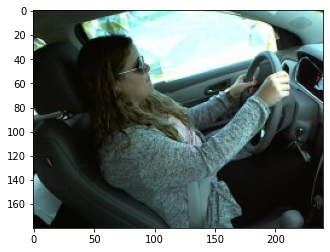

In [32]:
x = 0
plt.imshow(image_data[x])
print(image_data[x].shape)
print(pred_labels[x])
print(pred_data[x])